In [ ]:
DATA620 final project by Team 6 
Sub-Part:
How to make a meaningful sentimental analysis?
Version: 0717/2019 11:28 Eastern Time

In [25]:
import pandas as pd
import json
import numpy as np
from twython import Twython
import time
import os
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import re
from IPython.display import clear_output
import timeit
from PIL import Image
import random
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Lets load the twitter credentials

In [2]:
# Code below adapated from: https://stackabuse.com/accessing-the-twitter-api-with-python/
# Load Twitter API credentials from json file
with open("twitter_credentials.json", "r") as file:  
    creds = json.load(file)

# Instantiate an object and provide Twitter credentials
twitter = Twython(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET_KEY'], creds['ACCESS_TOKEN'], creds['ACCESS_SECRET_TOKEN'])

Lets use the previously downloaded Mike Gravel 1st level followers list to there tweets. To limit the number of followers will be using first 5K followers and download their tweets and perfrom analysis on them. 

In [3]:
with open("mikegravel1561157054.0137448_followers.json", "r") as file:
    followers = json.load(file)
followers = followers['screen_name'][:5000]#limiting followers count to 5K

As we are using tweets folder as a place where we store all the downloaded tweets so we will get the list of users who's tweets we already downloaded so we do not download them again.

In [4]:
done_users = []
files_names = []
for i in os.listdir('tweets'):
    done_users.append(i.split("#")[0])
    files_names.append(i)
remaining_users = list(set(followers) - set(done_users))

In [5]:
#download function
def get_users_tweets_json(username):
    next_cursor = -1
    tweets = []
    result = ""
    while(next_cursor):
        try:
            result = twitter.get_user_timeline(screen_name=username, count = 200, cursor=next_cursor)
            for tweet in result:
                tweets.append(tweet)
            try: 
                time.sleep(5)
                next_cursor = result["next_cursor"]
                print("Getting more of %s's followers' tweets" % username)
                print (time.asctime())
            except:
                break
        except:
            f=open("ignore.txt","a+")
            f.write(username + "\n")
            f.close()
            break
    filename=username + "#" + str(time.time()) + "_tweets.json"
    
    with open("tweets/" + filename, "w") as file:
        json.dump(tweets, file)
        
    print("Saving %s's tweets to JSON file" % username)
    print (time.asctime())
    return result

Lets download those tweets from followers

In [6]:
#download and save those tweets
for user in remaining_users:
    result = get_users_tweets_json(user)

Lets Read all the downloaded tweets into a list of list

In [7]:
tweets = []
count = 0
for file in files_names:
    clear_output(wait=True)
    with open("tweets/" + file, "r", encoding="utf-8") as file: 
        data = json.load(file)
        count = count +1
        if len(data)==0:
            continue
        for row in data:
            t = row["text"]
            t = re.sub(r"http\S+", "", t) # remove links from tweet
            t = re.sub(r"RT", "", t) # remove links from tweet
            t = re.sub(r"\n", "", t) # remove links from tweet
            screen_name = row['user']['screen_name']
            verified = row['user']['verified']
            tweet = [screen_name, verified, t]
            tweets.append(tweet)
    display('Extracted Tweets {}/{}'.format(count, len(files_names)))
print("Done Extracting Tweets!")

'Extracted Tweets 5256/6270'

Done Extracting Tweets!


In [10]:
print('Total Number of Tweets Extracted! {}'.format(len(tweets)))

Total Number of Tweets Extracted! 830591


In [11]:
verified_users_tweets = []
unverified_users_tweets = []
for tweet in tweets:
    if tweet[1]:
        verified_users_tweets.append(tweet)
    else:
        unverified_users_tweets.append(tweet)
print("Total Verified Users Tweets : {}".format(len(verified_users_tweets)))
print("Total Un-Verified Users Tweets : {}".format(len(unverified_users_tweets)))
print("Total Verified Users Tweets Percentage : {}".format(len(verified_users_tweets)/len(unverified_users_tweets)*100))

Total Verified Users Tweets : 12198
Total Un-Verified Users Tweets : 818393
Total Verified Users Tweets Percentage : 1.4904819567127283


Over Tweets Word Cloud

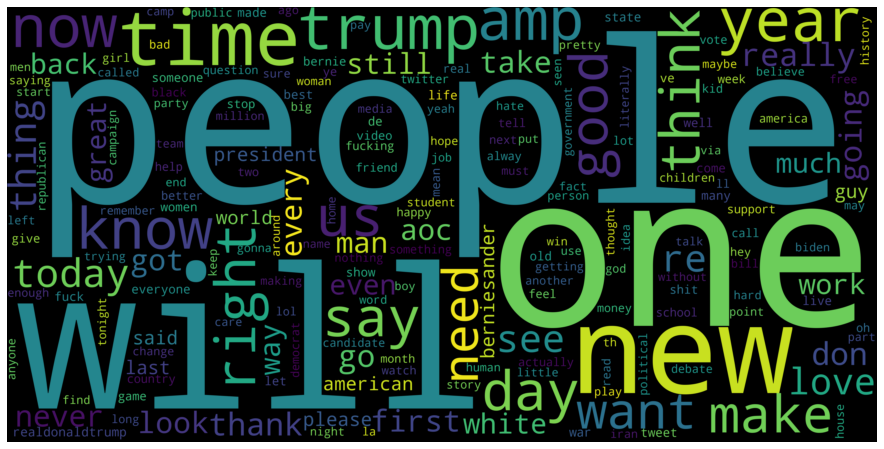

In [16]:
tweet_corpus = ""
for tweet in tweets:
    tweet_corpus = tweet_corpus +" ".join([w for w in tweet[2].lower().split(" ") if not w in STOPWORDS])

tweet_wordcloud = WordCloud(collocations = False, height=2000, width=4000)
freq = tweet_wordcloud.process_text(tweet_corpus)
tweet_wordcloud.generate_from_frequencies(freq)
# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(tweet_wordcloud,interpolation='bilinear')
plt.axis('off');

Overview the word cloud of whole tweet_corpus.  We can see most frequent words are "people", "will", "new"... Those are general words and do not have political meaning.  Those political related words are not obvious such as berniesander, iran, war, president except Trump.  

Un Verified Followers WordCloud

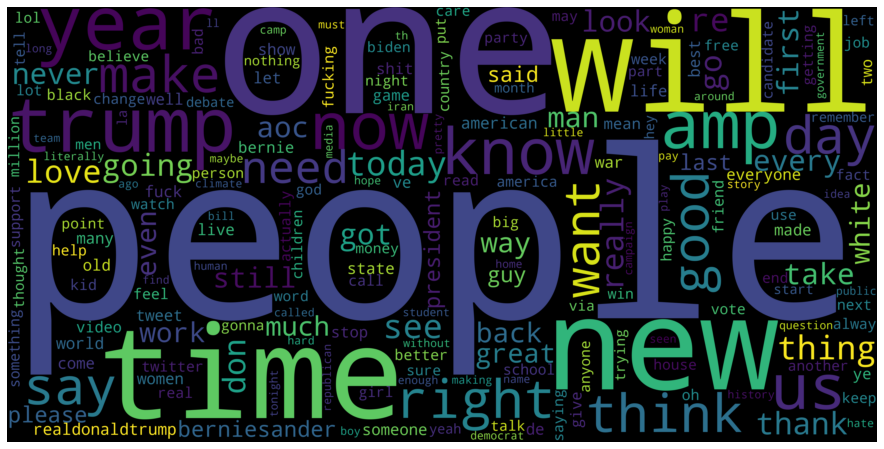

In [17]:
tweet_corpus = ""
for tweet in unverified_users_tweets:
    tweet_corpus = tweet_corpus +" ".join([w for w in tweet[2].lower().split(" ") if not w in STOPWORDS])

tweet_wordcloud = WordCloud(collocations = False, height=2000, width=4000)
freq = tweet_wordcloud.process_text(tweet_corpus)
tweet_wordcloud.generate_from_frequencies(freq)
# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(tweet_wordcloud,interpolation='bilinear')
plt.axis('off');

Look into un-verified users' tweet, it looks very similar to whole tweet_corpus.  The most poplar words are people, one, will, time, new...The political sensitive words are buried among them.  

Verified Followers WordCloud

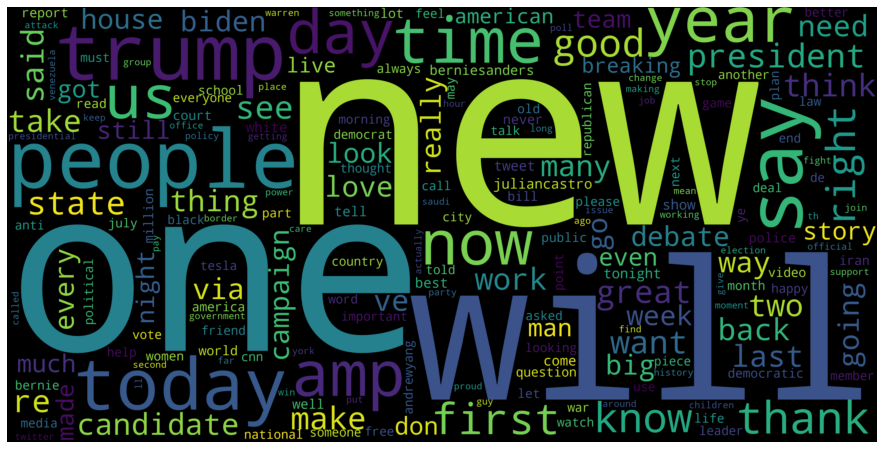

In [18]:
tweet_corpus = ""
for tweet in verified_users_tweets:
    tweet_corpus = tweet_corpus +" ".join([w for w in tweet[2].lower().split(" ") if not w in STOPWORDS])

tweet_wordcloud = WordCloud(collocations = False, height=2000, width=4000)
freq = tweet_wordcloud.process_text(tweet_corpus)
tweet_wordcloud.generate_from_frequencies(freq)
# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(tweet_wordcloud,interpolation='bilinear')
plt.axis('off');

Among verified users, the word frequency are quite different compared to the un-verified users and general corpus.  The most frequently appeared words are "new", "one", "will", "today","people"....So using this method to present the data will not attract audience who are interested in political campaign.  We must let those political sensitive words stands out.  After read some related reference and discuss with our teammate, especially Scott, we changed approach by using hastags to discover political related words.  By using this approach, we let the words we are targeting stands out than those general words.


As we observed that we do not make much sense of the word cloud in our context lets try to use hashtags to discover topics related to polictics

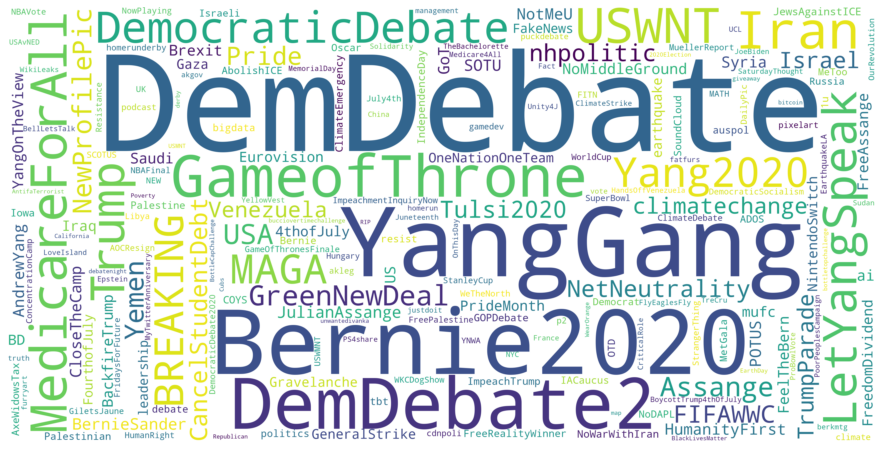

In [38]:
hashtag_corpus = ""
for tweet in tweets:
    hashtags = re.findall(r"(#\w+)", tweet[2])
    hashtag_corpus = hashtag_corpus +" ".join(hashtags)

hashtag_wordcloud = WordCloud(collocations = False,background_color="white", height=2000, width=4000, mode="RGB")
image_colors = ImageColorGenerator(usa_mask)
freq = hashtag_wordcloud.process_text(hashtag_corpus)
hashtag_wordcloud.generate_from_frequencies(freq)
# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(hashtag_wordcloud,interpolation='bilinear')
plt.axis('off');

Using hastage, we can see those political sensitive words stand out.  We can feel what is the politic hot topics or political trends accroding to the tweets.  Using this way, it will lead us for political trends forecast.  That is our aim.

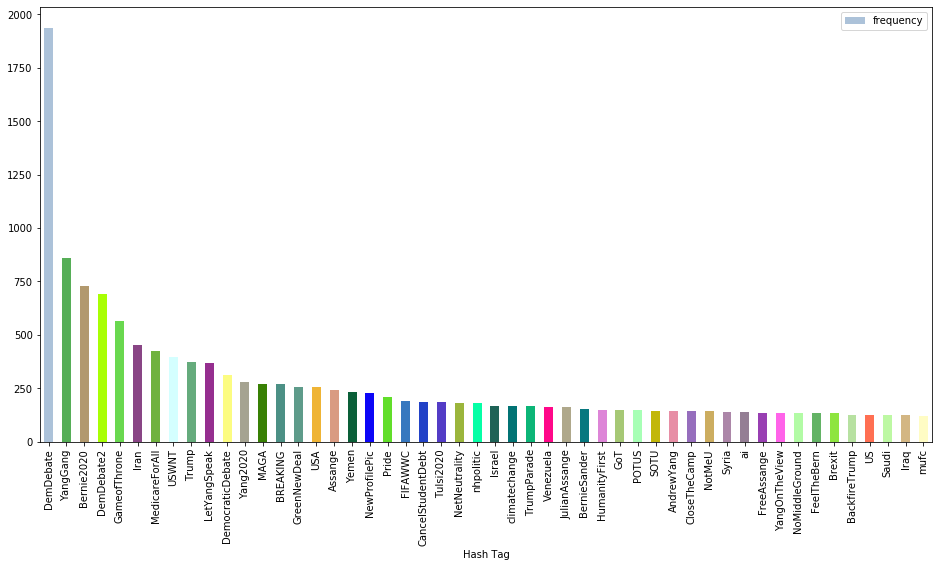

In [39]:
freq_list = sorted(freq.items(), key=lambda x: x[1], reverse=True)[:50]
df = pd.DataFrame(freq_list, columns=['Hash Tag', 'frequency'])
df.plot(kind='bar',x='Hash Tag',y='frequency', figsize = (16,8),color=list(colors._colors_full_map.values()))

The word cloud and frequency plots shows most frequent word are matched each other.  It makes perfect sense for overview political campaign.

Now that we have information about the major hashtags so lets construct a list of these words to find all the tweets related to politics

In [40]:
seed_words = ['DemDebate', 'YangGang', 'Bernie2020','DemDebate2','Iran','MedicareForAll','Trump','LetYangSpeak','DemocraticDebate','Yang2020','MAGA','Yemen','CancelStudentDebt','nhpolitic','Israel','TrumpParade','Venezuela','BernieSander','POTUS','AndrewYang','Syria','YangOnTheView','FeelTheBern','BackfireTrump','Saudi','Iraq']
#Lets do some pre-processing on the tweets dataset
cleaned_tweets = []
for tweet in tweets:
    tweet = re.sub(r"http\S+", "", tweet[2]) # remove links from tweet
    tweet = re.sub(r"RT", "", tweet) # remove links from tweet
    cleaned_tweets.append(tweet)
#Lets get all the tweets which have these hashtags
seed_tweets = []
for tweet in cleaned_tweets:
    if re.compile('|'.join(seed_words),re.IGNORECASE).search(tweet):
        seed_tweets.append(tweet)
seed_tweets = list(set(seed_tweets))

Now that we have all the tweets related to American Politics lets perfrom a WordCloud and Bar plot

In [43]:
print(len(seed_tweets))

49513


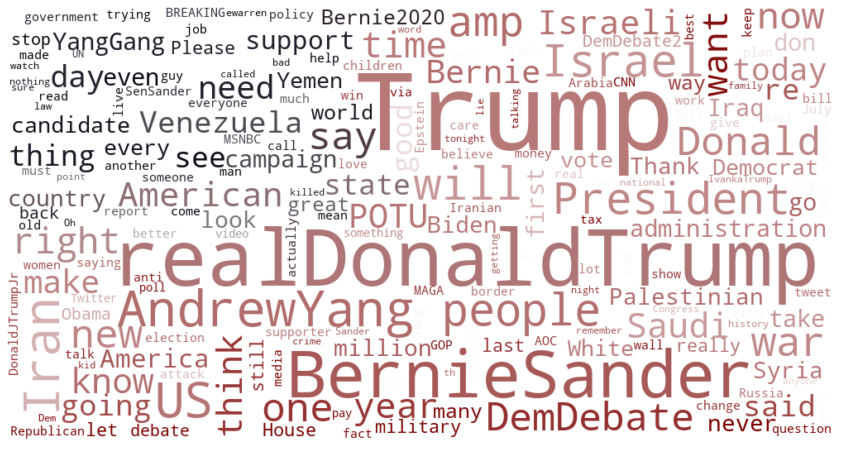

In [44]:
usa_mask = np.array(Image.open("usa.jpg"))
corpus = ""
for tweet in seed_tweets:
    corpus = corpus + " " + tweet

hashtag_wordcloud = WordCloud(collocations = False,background_color="white",height=2000, width=4000, mode="RGB",mask=usa_mask)
image_colors = ImageColorGenerator(usa_mask)
freq = hashtag_wordcloud.process_text(corpus)
hashtag_wordcloud.generate_from_frequencies(freq)
# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(hashtag_wordcloud.recolor(color_func=image_colors),interpolation='bilinear')
plt.axis('off');

From the tweets, we can see most popular words are "trump","realdonaldtrump", "berniesander", "andrewyang", "iran"...  Those makes perfect sense.  

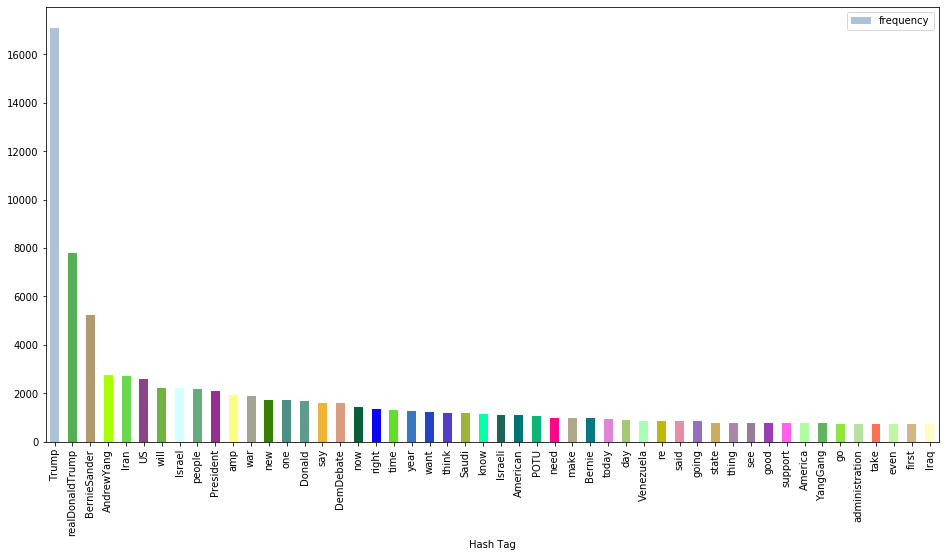

In [45]:
freq_list = sorted(freq.items(), key=lambda x: x[1], reverse=True)[:50]
df = pd.DataFrame(freq_list, columns=['Hash Tag', 'frequency'])
df.plot(kind='bar',x='Hash Tag',y='frequency', figsize = (16,8),color=list(colors._colors_full_map.values()))

Word frequecy plot confirms the findings in word cloud.

In [46]:
df = pd.DataFrame({'tweets':seed_tweets})
analyzer = SentimentIntensityAnalyzer()
tweets_list = []
for index, row in df.iterrows():
    score = analyzer.polarity_scores(row[0])
    temp = [row[0],score['pos'],score['neg'],score['neu'],score['compound']]
    tweets_list.append(temp)

Top 20 Positive Tweets

In [47]:
df_sentiments = pd.DataFrame.from_records(tweets_list, columns=(['Tweet','Positive','Negative','Neutral','Compound']))
df_sentiments = df_sentiments.sort_values('Compound',ascending=False)
pd.options.display.max_colwidth = 120
df_sentiments.head(20)

,Tweet,Positive,Negative,Neutral,Compound
3150,"@NelsonxShawn: love is love is love is love is love, and love will always trump hate.",0.665,0.098,0.237,0.9735
15433,"@mang_spider: Dear #YangGang Happy 4th of July. Enjoy time with your friends and family. Have great food, enjoy the...",0.605,0.000,0.395,0.9719
11366,"@djrothkopf: But if we stand for what is best about America and hope for the best for Israel, then we must welcome ...",0.469,0.000,0.531,0.9700
20090,@AndrewYang: Happy 4th of July America! Hope you are celebrating with family and friends - have a wonderful holiday...,0.614,0.000,0.386,0.9669
42305,@realDonaldTrump: Congratulations to the U.S. Women’s Soccer Team on winning the World Cup! Great and exciting play...,0.576,0.000,0.424,0.9656
15069,"@DonaldJTrumpJr: Jeb! I love everything about my father. I love that he’s a fighter, I love that he has guts, I lov...",0.555,0.000,0.445,0.9622
46297,Amy Klobuchar: yeah I’m a woman who can win and I have won and won bigly and I can win again for you ok #DemDebate,0.548,0.000,0.452,0.9607
18643,"@ssouriyeh: I love lebanon just as much as I love syria too. Truly, truly the most beautiful place on earth",0.586,0.000,0.414,0.9606
11606,"@POTUS: I won't stop; I'll be right there with you as a citizen, inspired by your voices of truth and justice, good...",0.555,0.000,0.445,0.9583
12579,@SenRickScott: Happy birthday to President @realDonaldTrump! Ann and I hope you have a great day! to wish President...,0.558,0.000,0.442,0.9564


Top 20 Positive Word Cloud

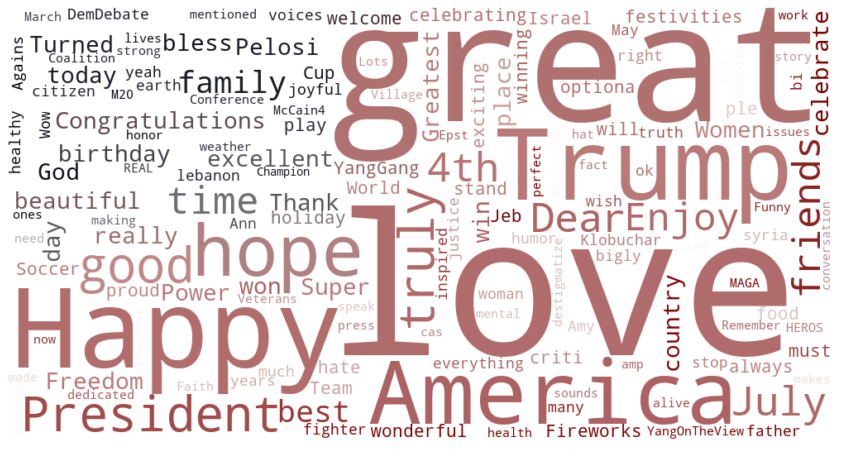

In [53]:
usa_mask = np.array(Image.open("usa.jpg"))
corpus = ""
for tweet in df_sentiments.head(20)['Tweet'].tolist():
    tweet = re.sub(r"(?:\@|https?\://)\S+", "", tweet)
    corpus = corpus + " " + tweet

hashtag_wordcloud = WordCloud(collocations = False,background_color="white",height=2000, width=4000, mode="RGB",mask=usa_mask)
image_colors = ImageColorGenerator(usa_mask)
freq = hashtag_wordcloud.process_text(corpus)
hashtag_wordcloud.generate_from_frequencies(freq)
# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(hashtag_wordcloud.recolor(color_func=image_colors),interpolation='bilinear')
plt.axis('off');

Top 20 Negative Tweets

In [48]:
df_sentiments.tail(20)

,Tweet,Positive,Negative,Neutral,Compound
39601,@Betelgeuse100: A herd (plague) of Israeli “soldiers” (nothing but illegal colonial terrorists in uniforms) continu...,0.000,0.512,0.488,-0.9568
41957,@alneamyyy88: #Yemen A real disaster to die conscience ..And die sense of others ..And death of nobility and esteem...,0.077,0.524,0.399,-0.9571
17206,@MAGA_NightShift @RealJamesWoods Bombing abortion clinics. Killing doctors. Molesting children. Raping women. Are yo...,0.000,0.607,0.393,-0.9583
4072,@nikoCSFB: Few Examples of Foreign:- No More Presidential Wars Act- Stop Arming Terrorist Act- Bill To Stop War In ...,0.000,0.544,0.456,-0.9588
19020,"@MarkRuffalo: This war has killed 85,000 children. It’s an immoral and useless war. America should wash its hands o...",0.000,0.516,0.484,-0.9590
28790,@ThirdWayMattB @BernieSanders SHUT THE FUCK UP YOU LYING ASS BITCH,0.000,0.741,0.259,-0.9592
2638,Everyone except Trump this debate: FUCKING WW3 BITCHES ARM UKRAINE KILL OUR SONS DEATH TO PALESTINE honestly what th...,0.081,0.516,0.404,-0.9594
23832,@funder @jkchildress67 Trump is a child molester he is a rapist he is an idiot he is a criminal he is a thief why c…,0.000,0.534,0.466,-0.9601
5963,@1Marchella: Same lies used to sell the disastrous war with Iraq are now being used to sell an even more disastrous...,0.000,0.492,0.508,-0.9607
46106,"@dancohen3000: Saudi/UAE war planes aimed to kill Yemeni journalist Abdullah Sabri. They injured him, killed and in...",0.000,0.569,0.431,-0.9612


Top 20 Negative Tweets Word Cloud

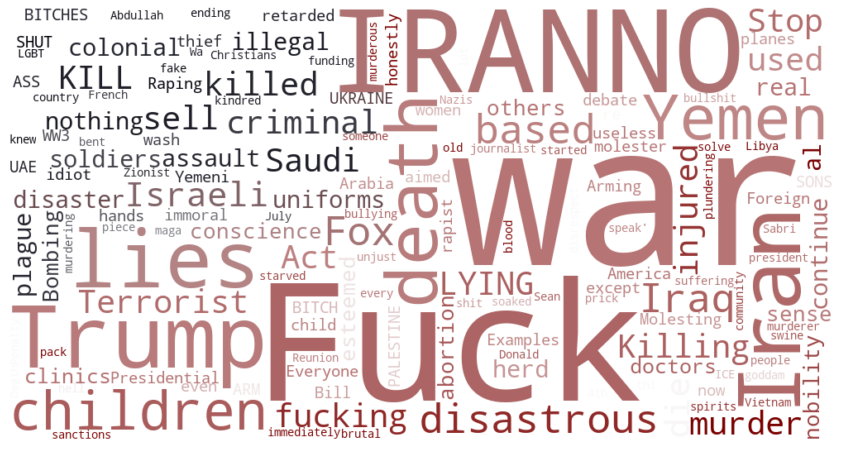

In [55]:
usa_mask = np.array(Image.open("usa.jpg"))
corpus = ""
for tweet in df_sentiments.tail(20)['Tweet'].tolist():
    tweet = re.sub(r"(?:\@|https?\://)\S+", "", tweet)
    corpus = corpus + " " + tweet

hashtag_wordcloud = WordCloud(collocations = False,background_color="white",height=2000, width=4000, mode="RGB",mask=usa_mask)
image_colors = ImageColorGenerator(usa_mask)
freq = hashtag_wordcloud.process_text(corpus)
hashtag_wordcloud.generate_from_frequencies(freq)
# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(hashtag_wordcloud.recolor(color_func=image_colors),interpolation='bilinear')
plt.axis('off');

Discussion: As we see, if we simply download tweeters, we can not see the political opinion in this group of users. All the most popular words are quite general.  After we link those words with hastage, then the political related words stand out.  We can see the political trends.  From the word could and word frequency, we can see the most interesting topics such as "Iran War", "Bernie Sander", "Andrew Yang", "Trump"...  Aboove is our preliminary study, there is still long way to go to make accurate predition such as (1) Democratic party or Republican party, which is more popular; (2) Who will win next president; (3) Which topics are more interesting for the voters.  